In [2]:
import numpy as np, pandas as pd, networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import community as community_louvain
import folium, imageio, os
from folium import GeoJson, Popup
from geopandas.tools import sjoin
from scipy.stats import gaussian_kde

# Proyecto 1
## Seminario 2 de Matemática Aplicada
## MM3024 Sección 10
### Jonathan Espinoza 20022
### Jeyner Arango 201106

### Mapeo de CDMX y ECOBICI

In [23]:
#AGEB Urbanas (Áreas geoestadísticas básicas urbanas)
agebs = gpd.read_file('agebs_cdmx.geojson')

In [24]:
agebs.head()

ageb_urbana_cvegeo                                           geometry
0      0900700013628  MULTIPOLYGON (((-99.03887 19.39128, -99.03851 ...
1      0900300011533  MULTIPOLYGON (((-99.18010 19.30772, -99.17845 ...
2      0901500010235  MULTIPOLYGON (((-99.14495 19.45625, -99.14536 ...
3      0900200010097  MULTIPOLYGON (((-99.20573 19.50454, -99.20630 ...
4      0900200011184  MULTIPOLYGON (((-99.20723 19.50387, -99.20652 ...

In [25]:
agebs.iloc[0,:]

ageb_urbana_cvegeo                                        0900700013628
geometry              MULTIPOLYGON (((-99.03887376191602 19.39127798...
Name: 0, dtype: object

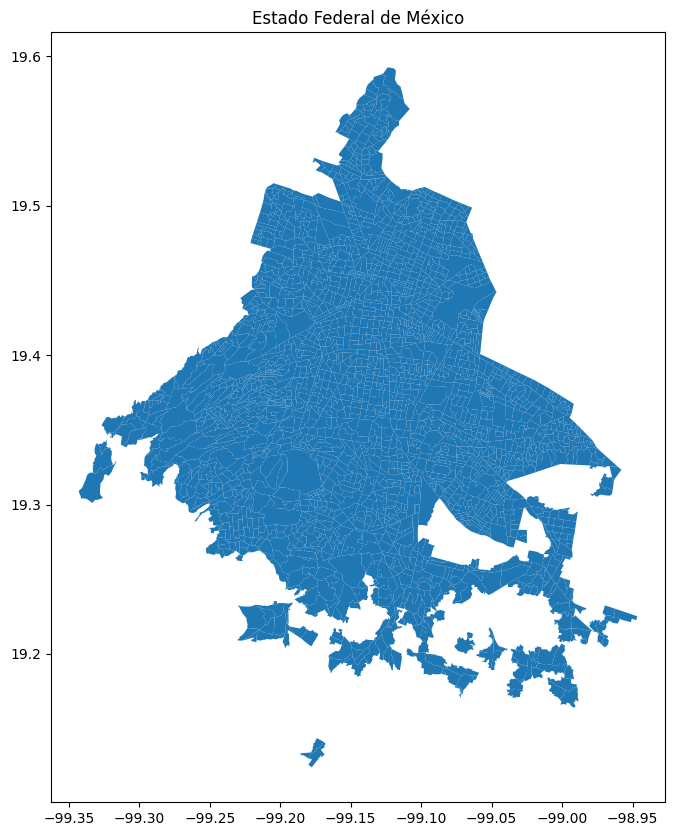

In [119]:
agebs.plot(figsize = (10,10))
plt.title('Estado Federal de México')
plt.show()
plt.savefig('estado_mexico_map.png')
plt.close()

In [27]:
# Lee los datos de las estaciones de bicicletas desde el archivo CSV
ciudad_mexico = agebs
estaciones_df = pd.read_csv('stations.csv')

# Convierte el DataFrame en un GeoDataFrame
estaciones_gdf = gpd.GeoDataFrame(estaciones_df, 
                                   geometry=gpd.points_from_xy(estaciones_df.lon, estaciones_df.lat))

estaciones_gdf.head()

id        lat        lon                           name  \
0   1  19.433571 -99.167809          1 RIO SENA-RIO BALSAS   
1   2  19.431386 -99.171695  2 RIO GUADALQUIVIR-RIO BALSAS   
2   3  19.431655 -99.158668          3 REFORMA-INSURGENTES   
3   4  19.428309 -99.171713          4 RIO NILO-RIO PANUCO   
4   5  19.429720 -99.169363         5 RIO PANUCO-RIO TIBER   

                     geometry  
0  POINT (-99.16781 19.43357)  
1  POINT (-99.17169 19.43139)  
2  POINT (-99.15867 19.43165)  
3  POINT (-99.17171 19.42831)  
4  POINT (-99.16936 19.42972)

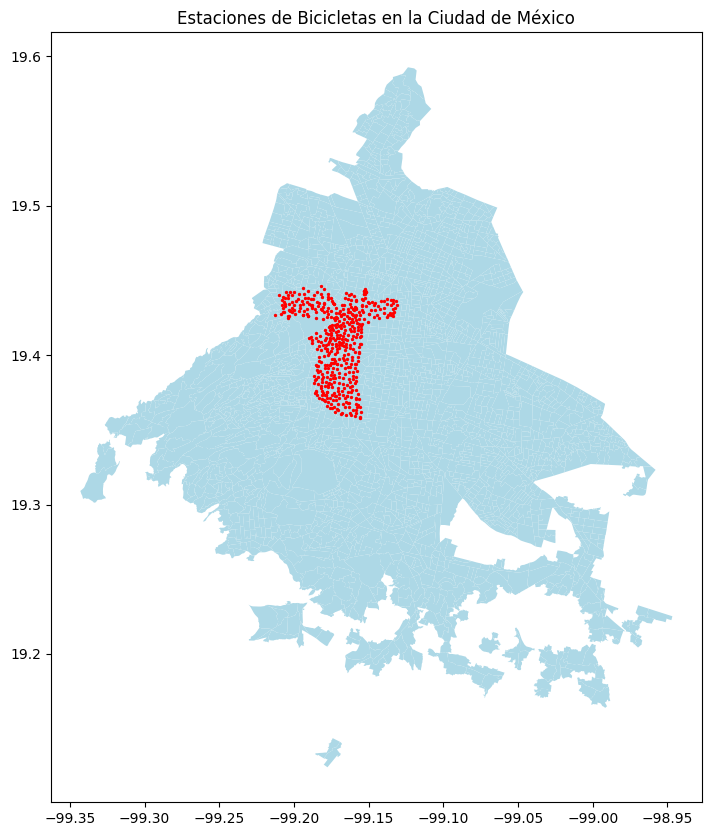

In [114]:
# Crea el mapa
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Estaciones de Bicicletas en la Ciudad de México')

# Plotea las estaciones
ciudad_mexico.plot(ax=ax, color='lightblue')
estaciones_gdf.plot(ax=ax, marker='o', color='red', markersize=2)

# Muestra el mapa
plt.show()

### Detección de AGEBS relevantes

In [9]:
clave_agebs = pd.read_excel('ClaveAgeb.xlsx')
clave_agebs.head()

Entidad       Municipio  ClaveLoc  \
0  Aguascalientes  Aguascalientes  10010001   
1  Aguascalientes  Aguascalientes  10010293   
2  Aguascalientes  Aguascalientes  10010001   
3  Aguascalientes  Aguascalientes  10010479   
4  Aguascalientes  Aguascalientes  10010357   

                                   Localidad     ClaveAgeb  \
0                             Aguascalientes  100100013238   
1                      Norias de Ojocaliente  100102933666   
2                             Aguascalientes  100100013149   
3  Villa Licenciado Jesús Terán (Calvillito)  100104792742   
4                      Norias del Paso Hondo  100103574166   

  Grado de marginalidad  PRIORIDAD  POBTOT  
0                  Alto      84.95    1315  
1              Muy alto      83.35    1738  
2              Muy alto      83.00    1885  
3                  Alto      83.00    1579  
4              Muy alto      82.80    1015

In [10]:
clave_agebs.columns

Index(['Entidad', 'Municipio', 'ClaveLoc', 'Localidad', 'ClaveAgeb',
       'Grado de marginalidad', 'PRIORIDAD', 'POBTOT'],
      dtype='object')

In [11]:
clave_agebs[clave_agebs['Entidad']=='Distrito Federal']['Municipio'].unique()

array(['Tlalpan', 'Xochimilco', 'Milpa Alta', 'Iztapalapa', 'Tláhuac',
       'Gustavo A. Madero', 'Azcapotzalco', 'Cuajimalpa de Morelos',
       'La Magdalena Contreras', 'Iztacalco', 'Cuauhtémoc',
       'Venustiano Carranza', 'Miguel Hidalgo', 'Coyoacán',
       'Benito Juárez', 'Álvaro Obregón'], dtype=object)

In [12]:
municipios_bicicletas = ['Benito Juárez', 'Cuauhtémoc', 'Miguel Hidalgo']

In [13]:
clave_agebs[(clave_agebs['Entidad']=='Distrito Federal') & (clave_agebs['Municipio'].isin(municipios_bicicletas))]

Entidad       Municipio  ClaveLoc       Localidad  \
4732  Distrito Federal      Cuauhtémoc  90150001      Cuauhtémoc   
4742  Distrito Federal  Miguel Hidalgo  90160001  Miguel Hidalgo   
4765  Distrito Federal      Cuauhtémoc  90150001      Cuauhtémoc   
4772  Distrito Federal      Cuauhtémoc  90150001      Cuauhtémoc   
4773  Distrito Federal      Cuauhtémoc  90150001      Cuauhtémoc   
...                ...             ...       ...             ...   
5789  Distrito Federal  Miguel Hidalgo  90160001  Miguel Hidalgo   
5790  Distrito Federal  Miguel Hidalgo  90160001  Miguel Hidalgo   
5791  Distrito Federal  Miguel Hidalgo  90160001  Miguel Hidalgo   
5792  Distrito Federal  Miguel Hidalgo  90160001  Miguel Hidalgo   
5793  Distrito Federal  Miguel Hidalgo  90160001  Miguel Hidalgo   

          ClaveAgeb Grado de marginalidad  PRIORIDAD  POBTOT  
4732   901500010771                 Medio      64.50    1154  
4742   901600010020                 Medio      63.25    2089  
4765   901500010818                  Bajo      62.10     249  
4772   901500011271                  Bajo      61.75    1894  
4773   901500011106                  Bajo      61.70    2127  
...             ...                   ...        ...     ...  
5789   901600011118                 Medio       0.00    6149  
5790   901600011137              Muy bajo       0.00    3740  
5791   901600011156                  Bajo       0.00    7599  
5792  090160001118A              Muy bajo       0.00    7418  
5793   901600011334                  Bajo       0.00    3317  

[167 rows x 8 columns]

In [14]:
mapeo_agebs = clave_agebs[(clave_agebs['Entidad']=='Distrito Federal') & (clave_agebs['Municipio'].isin(municipios_bicicletas))]['ClaveLoc'].unique()
mapeo_agebs = ['0' + str(cadena) for cadena in mapeo_agebs]
mapeo_agebs

['090150001', '090160001', '090140001']

In [15]:
mapeo_municipios = {
    '090140001': 'Benito Juárez',
    '090150001': 'Cuauhtémoc',
    '090160001': 'Miguel Hidalgo'
}

In [16]:
zona_interes = agebs[agebs['ageb_urbana_cvegeo'].str.startswith(tuple(mapeo_agebs))].copy()
zona_interes['municipio_cod']= zona_interes['ageb_urbana_cvegeo'].str.slice(0, 9)
zona_interes['municipio'] = zona_interes['municipio_cod'].map(mapeo_municipios)
zona_interes

ageb_urbana_cvegeo                                           geometry  \
2         0901500010235  MULTIPOLYGON (((-99.14495 19.45625, -99.14536 ...   
14        0901600010586  MULTIPOLYGON (((-99.18103 19.43906, -99.17938 ...   
28        0901400010670  MULTIPOLYGON (((-99.14169 19.36929, -99.14159 ...   
35        0901400010172  MULTIPOLYGON (((-99.13535 19.39143, -99.13597 ...   
40        0901400010581  MULTIPOLYGON (((-99.17232 19.38643, -99.17244 ...   
...                 ...                                                ...   
2324      0901600011353  MULTIPOLYGON (((-99.22203 19.43476, -99.22115 ...   
2325      0901600011264  MULTIPOLYGON (((-99.23375 19.40716, -99.23375 ...   
2326      0901600011368  MULTIPOLYGON (((-99.21909 19.43428, -99.21935 ...   
2327      0901600011298  MULTIPOLYGON (((-99.25344 19.40484, -99.25349 ...   
2330      0901600011300  MULTIPOLYGON (((-99.24841 19.39071, -99.24836 ...   

     municipio_cod       municipio  
2        090150001      Cuauhtémoc  
14       090160001  Miguel Hidalgo  
28       090140001   Benito Juárez  
35       090140001   Benito Juárez  
40       090140001   Benito Juárez  
...            ...             ...  
2324     090160001  Miguel Hidalgo  
2325     090160001  Miguel Hidalgo  
2326     090160001  Miguel Hidalgo  
2327     090160001  Miguel Hidalgo  
2330     090160001  Miguel Hidalgo  

[386 rows x 4 columns]

In [17]:
zona_interes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

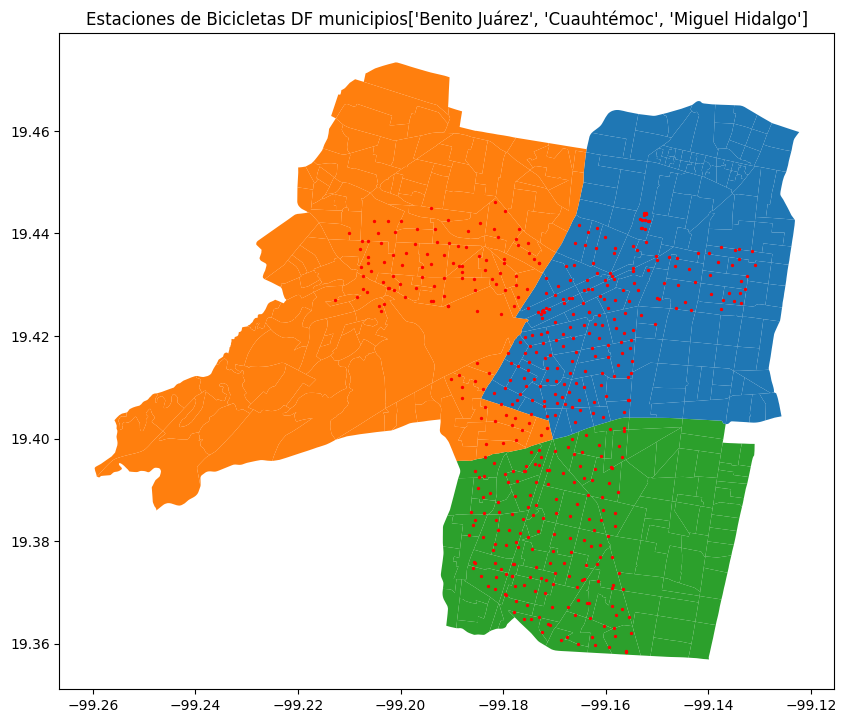

In [18]:
# Crea el mapa
fig, ax = plt.subplots(figsize=(10, 10))
# Creamos un mapeo de colores únicos para cada valor único en 'municipio'
colores_por_municipio = {municipio: color for municipio, color in zip(zona_interes['municipio'].unique(), plt.cm.tab10.colors)}
# Mapeamos los valores de 'municipio' a colores
colores = zona_interes['municipio'].map(colores_por_municipio)
# Ploteamos el DataFrame 'zona_interes' utilizando los colores
ax.set_title('Estaciones de Bicicletas DF municipios' +str(municipios_bicicletas))

# Plotea las estaciones
zona_interes.plot(ax=ax, color=colores)
estaciones_gdf.plot(ax=ax, marker='o', color='red', markersize=2)

# Muestra el mapa
plt.show()

In [19]:
# Define el CRS proyectado que deseas utilizar (UTM 14N)
crs_proyectado = 'EPSG:32614'

# Proyecta las geometrías a un CRS proyectado
zona_interes_proyectada = zona_interes.to_crs(crs_proyectado)

# Calcula el área por polígono en el CRS proyectado
zona_interes_proyectada['area'] = zona_interes_proyectada.geometry.area

# Suma el área por municipio
area_por_municipio = zona_interes_proyectada.groupby('municipio')['area'].sum() /1000000

# Calcula el área total de todos los polígonos
area_total = zona_interes_proyectada['area'].sum() / 1000000

# Calcula el porcentaje de área de cada municipio con respecto al área total
porcentaje_area_por_municipio = (area_por_municipio / area_total) * 100

# Mostrar el resultado
print("Área por municipio:")
for municipio, area_km2 in area_por_municipio.items():
    print(f'{area_km2:.2f} km² en {municipio}')
# Mostrar el resultado del porcentaje de área por municipio con respecto al área total
print("\nPorcentaje de área por municipio con respecto al área total:")
for municipio, porcentaje in porcentaje_area_por_municipio.items():
    print(f'{porcentaje:.2f}% en {municipio}')

Área por municipio:
26.68 km² en Benito Juárez
32.50 km² en Cuauhtémoc
46.39 km² en Miguel Hidalgo

Porcentaje de área por municipio con respecto al área total:
25.27% en Benito Juárez
30.78% en Cuauhtémoc
43.94% en Miguel Hidalgo


In [20]:
estaciones_gdf = estaciones_gdf.set_crs('EPSG:4326')
estaciones_con_ageb = gpd.sjoin(estaciones_gdf, zona_interes[['ageb_urbana_cvegeo', 'geometry','municipio']], how="left", predicate="within").drop(columns=['index_right'])
estaciones_con_ageb

id        lat        lon                                  name  \
0      1  19.433571 -99.167809                 1 RIO SENA-RIO BALSAS   
1      2  19.431386 -99.171695         2 RIO GUADALQUIVIR-RIO BALSAS   
2      3  19.431655 -99.158668                 3 REFORMA-INSURGENTES   
3      4  19.428309 -99.171713                 4 RIO NILO-RIO PANUCO   
4      5  19.429720 -99.169363                5 RIO PANUCO-RIO TIBER   
..   ...        ...        ...                                   ...   
475  476  19.442127 -99.184433        476 LAGO COMO-LAGUNA DE MAYRÁN   
476  477  19.440905 -99.181743       477 LAGO ISEO-LAGUNA DE MAYRÁN    
477  478  19.440818 -99.176961      478 LAGUNA DE MAYRÁN-LAGO CHALCO   
478  479  19.444433 -99.179664  E479 LAGO MURITZ-AV. MARINA NACIONAL   
479  480  19.446073 -99.181654     480 LAGO ISEO-AV. MARINA NACIONAL   

                       geometry ageb_urbana_cvegeo       municipio  
0    POINT (-99.16781 19.43357)      0901500010790      Cuauhtémoc  
1    POINT (-99.17169 19.43139)      0901500010926      Cuauhtémoc  
2    POINT (-99.15867 19.43165)      0901500010729      Cuauhtémoc  
3    POINT (-99.17171 19.42831)      0901500010926      Cuauhtémoc  
4    POINT (-99.16936 19.42972)      0901500010822      Cuauhtémoc  
..                          ...                ...             ...  
475  POINT (-99.18443 19.44213)      0901600010478  Miguel Hidalgo  
476  POINT (-99.18174 19.44091)      0901600010482  Miguel Hidalgo  
477  POINT (-99.17696 19.44082)      0901600010482  Miguel Hidalgo  
478  POINT (-99.17966 19.44443)      0901600010482  Miguel Hidalgo  
479  POINT (-99.18165 19.44607)      0901600010482  Miguel Hidalgo  

[480 rows x 7 columns]

### Selección de AGEBS

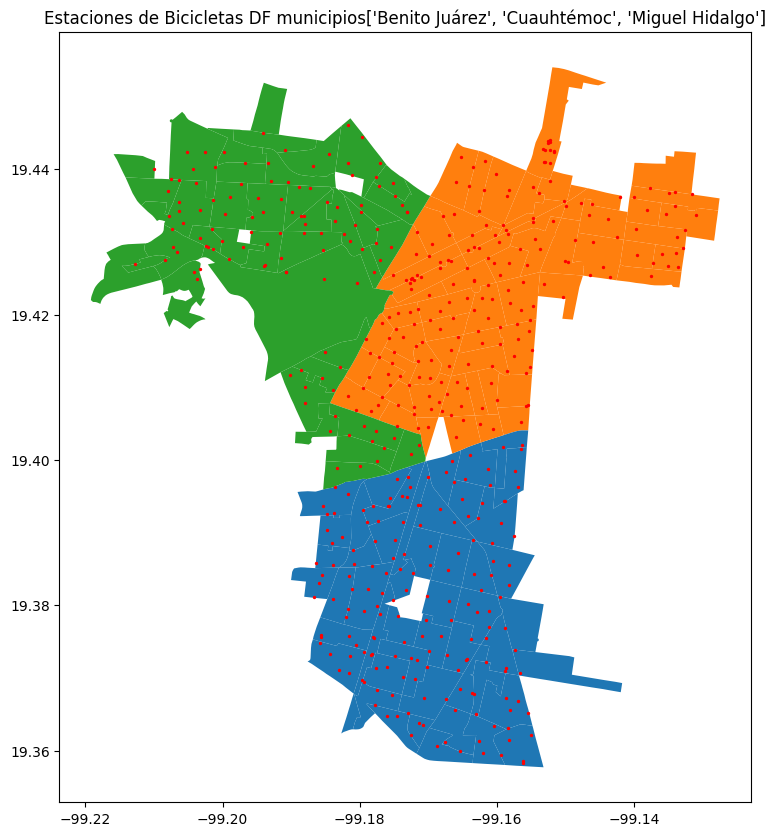

In [21]:
# Crea el mapa
fig, ax = plt.subplots(figsize=(10, 10))

# Filtra los polígonos de zona_interes que coinciden con los valores de ageb_urbana_cvegeo en estaciones_con_ageb
poligonos_seleccionados = zona_interes[zona_interes['ageb_urbana_cvegeo'].isin(estaciones_con_ageb['ageb_urbana_cvegeo'])]

# Creamos un mapeo de colores únicos para cada valor único en 'municipio'
colores_por_municipio = {municipio: color for municipio, color in zip(poligonos_seleccionados['municipio'].unique(), plt.cm.tab10.colors)}

# Mapeamos los valores de 'municipio' a colores
colores = poligonos_seleccionados['municipio'].map(colores_por_municipio)

# Ploteamos el DataFrame 'poligonos_seleccionados' utilizando los colores
poligonos_seleccionados.plot(ax=ax, color=colores)

# Plotea las estaciones
estaciones_gdf.plot(ax=ax, marker='o', color='red', markersize=2)

# Ajusta el título del gráfico
ax.set_title('Estaciones de Bicicletas DF municipios' + str(municipios_bicicletas))

# Muestra el mapa
plt.show()

In [22]:
len(poligonos_seleccionados['ageb_urbana_cvegeo'].unique())

144

In [23]:
zona_interes_faltante = zona_interes[zona_interes['ageb_urbana_cvegeo'].isin(['0901500011445', '0901600010586', '0901600010764','0901400010596'])]
poligonos_seleccionados = pd.concat([poligonos_seleccionados, zona_interes_faltante], ignore_index=True)

In [24]:
len(poligonos_seleccionados['ageb_urbana_cvegeo'].unique())

148

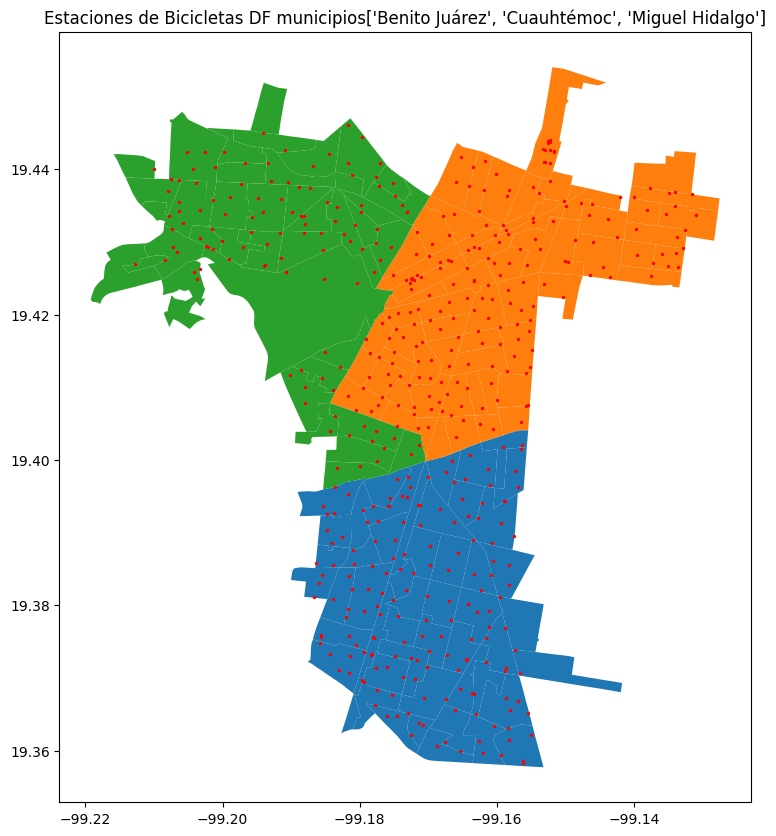

In [25]:
# Crea el mapa
fig, ax = plt.subplots(figsize=(10, 10))

# Creamos un mapeo de colores únicos para cada valor único en 'municipio'
colores_por_municipio = {municipio: color for municipio, color in zip(poligonos_seleccionados['municipio'].unique(), plt.cm.tab10.colors)}

# Mapeamos los valores de 'municipio' a colores
colores = poligonos_seleccionados['municipio'].map(colores_por_municipio)

# Ploteamos el DataFrame 'poligonos_seleccionados' utilizando los colores
poligonos_seleccionados.plot(ax=ax, color=colores)

# Plotea las estaciones
estaciones_gdf.plot(ax=ax, marker='o', color='red', markersize=2)

# Ajusta el título del gráfico
ax.set_title('Estaciones de Bicicletas DF municipios' + str(municipios_bicicletas))

# Muestra el mapa
plt.show()

In [26]:
poligonos_seleccionados_proyectados = poligonos_seleccionados.to_crs('EPSG:32614')
poligonos_seleccionados_proyectados['area'] = poligonos_seleccionados_proyectados.geometry.area / 1e6  # Convertir de m² a km²
poligonos_seleccionados_proyectados

ageb_urbana_cvegeo                                           geometry  \
0        0901400010581  MULTIPOLYGON (((481905.313 2143595.120, 481892...   
1        0901500011017  MULTIPOLYGON (((483869.067 2147955.234, 483852...   
2        0901400010948  MULTIPOLYGON (((482060.866 2140817.701, 482011...   
3        090150001138A  MULTIPOLYGON (((483228.120 2146329.276, 483232...   
4        0901500011479  MULTIPOLYGON (((483307.166 2145472.916, 483279...   
..                 ...                                                ...   
143      0901600011226  MULTIPOLYGON (((482104.933 2145073.113, 481913...   
144      0901600010586  MULTIPOLYGON (((480996.824 2149419.923, 481170...   
145      0901600010764  MULTIPOLYGON (((479261.946 2148612.067, 479355...   
146      0901400010596  MULTIPOLYGON (((481708.390 2142751.108, 481706...   
147      0901500011445  MULTIPOLYGON (((482520.583 2145193.212, 482452...   

    municipio_cod       municipio      area  
0       090140001   Benito Juárez  0.152425  
1       090150001      Cuauhtémoc  0.391660  
2       090140001   Benito Juárez  0.116166  
3       090150001      Cuauhtémoc  0.250222  
4       090150001      Cuauhtémoc  0.170074  
..            ...             ...       ...  
143     090160001  Miguel Hidalgo  0.215030  
144     090160001  Miguel Hidalgo  0.107973  
145     090160001  Miguel Hidalgo  0.038496  
146     090140001   Benito Juárez  0.217991  
147     090150001      Cuauhtémoc  0.153937  

[148 rows x 5 columns]

In [27]:
poligonos_seleccionados_proyectados['area'].sum()

43.00923446124182

In [28]:
area_total_poligonos_seleccionados_por_municipio = poligonos_seleccionados_proyectados.groupby('municipio')['area'].sum()
area_total_poligonos_seleccionados_por_municipio

municipio
Benito Juárez     14.264150
Cuauhtémoc        14.565977
Miguel Hidalgo    14.179107
Name: area, dtype: float64

In [29]:
cobertura_por_municipio = area_total_poligonos_seleccionados_por_municipio / area_por_municipio * 100
print("\nPorcentaje de cobertura de red de bicicletas respecto al área total por municipio :")
for municipio, porcentaje in cobertura_por_municipio.items():
    print(f'{porcentaje:.2f}% en {municipio}')


Porcentaje de cobertura de red de bicicletas respecto al área total por municipio :
53.46% en Benito Juárez
44.82% en Cuauhtémoc
30.57% en Miguel Hidalgo


### Superposición sobre Open Street Maps

In [80]:
# Crea un mapa centrado en la ubicación de interés
m = folium.Map(location=[19.408970, -99.171276], zoom_start=13)

# Itera sobre cada fila en zona_interes para agregar los polígonos al mapa
for idx, row in poligonos_seleccionados.iterrows():
    # Convierte el polígono a GeoJSON
    geojson = row.geometry.__geo_interface__
    
    # Crea un objeto GeoJson para el polígono
    geojson_layer = GeoJson(geojson,
                            style_function=lambda feature: {'fillColor': 'blue', 'fillOpacity': 0.5, 'color': 'blue'},
                            tooltip=row['ageb_urbana_cvegeo'])
    
    # Crea un popup con información adicional sobre el polígono
    popup = Popup(row['ageb_urbana_cvegeo'])
    popup.add_to(geojson_layer)
    
    # Agrega el objeto GeoJson al mapa
    geojson_layer.add_to(m)

# Muestra el mapa
m

In [81]:
# Crea un mapa centrado en la ubicación de interés
m = folium.Map(location=[19.408970, -99.171276], zoom_start=13)

# Itera sobre cada fila en zona_interes para agregar los polígonos al mapa
for idx, row in poligonos_seleccionados.iterrows():
    # Convierte el polígono a GeoJSON
    geojson = row.geometry.__geo_interface__
    
    # Crea un objeto GeoJson para el polígono
    geojson_layer = GeoJson(geojson,
                            style_function=lambda feature: {'fillColor': 'blue', 'fillOpacity': 0.5, 'color': 'blue'},
                            tooltip=row['ageb_urbana_cvegeo'])
    
    # Crea un popup con información adicional sobre el polígono
    popup = Popup(row['ageb_urbana_cvegeo'])
    popup.add_to(geojson_layer)
    
    # Agrega el objeto GeoJson al mapa
    geojson_layer.add_to(m)

# Itera sobre cada fila en estaciones_con_ageb para agregar los puntos al mapa
for idx, row in estaciones_con_ageb.iterrows():
    # Agrega un marcador para cada punto
    folium.Marker([row.geometry.y, row.geometry.x], tooltip=row['name'],  icon=folium.Icon(icon_size=(0.1, 0.1))).add_to(m)

# Muestra el mapa
m

### Mapeo de densidad poblacional

In [30]:
poblacion = pd.read_csv('poblacion_cdmx.csv', index_col = 'ageb_urbana_cvegeo')
poblacion['pob_total'] = poblacion.sum(axis = 1)
poblacion.head()

pob_0a2  pob_3a5  pob_6a11  pob_12a14  pob_15a17  \
ageb_urbana_cvegeo                                                     
0900200010010            71       77       235        129        137   
0900200010025           206      241       466        212        261   
090020001003A           157      137       347        202        197   
0900200010044           148      162       391        178        203   
0900200010097            56       82       150         80         88   

                    pob_18a24  pob_25a29  pob_30a49  pob_50a59  pob_60ymas  \
ageb_urbana_cvegeo                                                           
0900200010010             298        182       1055        293         822   
0900200010025             622        426       1705        699         974   
090020001003A             478        273       1395        370         902   
0900200010044             459        365       1422        469         993   
0900200010097             202        157        626        248         523   

                    pob_total  
ageb_urbana_cvegeo             
0900200010010            3299  
0900200010025            5812  
090020001003A            4458  
0900200010044            4790  
0900200010097            2212

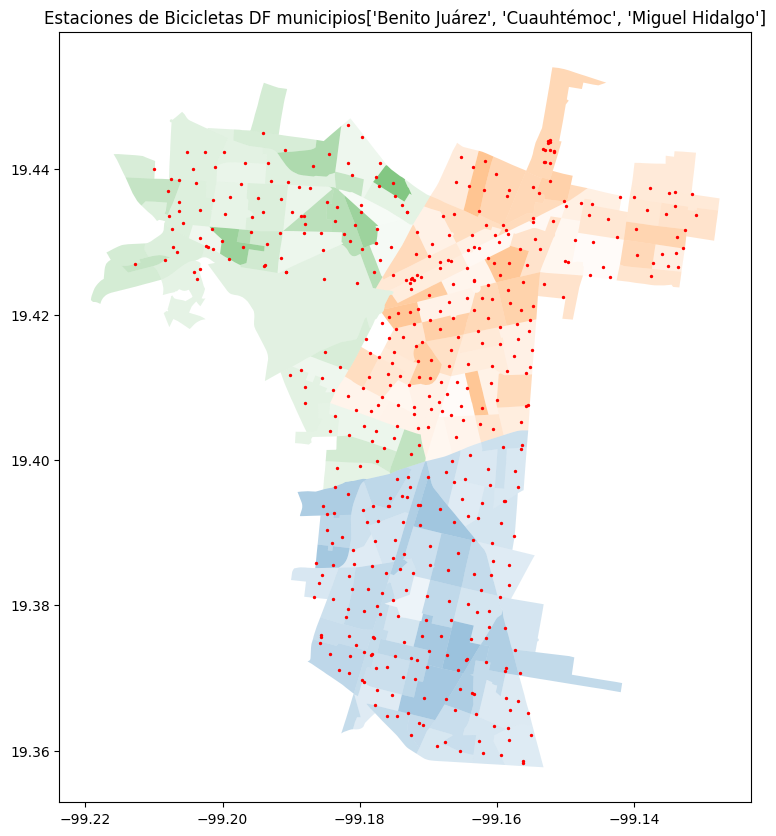

In [31]:
# Crea el mapa
fig, ax = plt.subplots(figsize=(10, 10))

# Mapeo de colores únicos para cada valor único en 'municipio'
colores_por_municipio = {municipio: plt.cm.tab10(i) for i, municipio in enumerate(poligonos_seleccionados['municipio'].unique())}

# Mapea los valores de 'municipio' a colores
colores = poligonos_seleccionados['municipio'].map(colores_por_municipio)

# Ajusta la intensidad del color basada en la población total
poblacion_maxima = poblacion['pob_total'].max()  # Obtén el valor máximo de población total
intensidades = poblacion['pob_total'] / poblacion_maxima  # Normaliza la población total

# Ajusta la transparencia de los colores según las intensidades
colores_alpha = [(color[0], color[1], color[2], intensidad) for color, intensidad in zip(colores, intensidades)]

# Plotea el DataFrame 'poligonos_seleccionados' utilizando los colores y transparencias
poligonos_seleccionados.plot(ax=ax, color=colores_alpha)

# Plotea las estaciones
estaciones_gdf.plot(ax=ax, marker='o', color='red', markersize=2)

# Ajusta el título del gráfico
ax.set_title('Estaciones de Bicicletas DF municipios' + str(municipios_bicicletas))

# Muestra el mapa
plt.show()

In [32]:
# Función para crear una imagen con polígonos seleccionados
def crear_imagen_poligonos(titulo):
    fig, ax = plt.subplots(figsize=(10, 10))
    poligonos_seleccionados.plot(ax=ax, color=colores)
    ax.set_title(titulo)
    ax.axis('off')  # Desactiva los ejes
    plt.tight_layout()
    return fig

# Función para agregar estaciones y líneas a la imagen
def agregar_estaciones_y_lineas(fig, estaciones, paso):
    ax = fig.gca()  # Obtiene el eje actual
    for i in range(paso + 1):  # Dibuja todas las estaciones hasta el paso actual
        estacion = estaciones.iloc[i]
        ax.plot(estacion.geometry.x, estacion.geometry.y, 'ro')  # Agrega la estación
    if paso > 0:  # Solo dibuja la línea si hay al menos dos estaciones
        estacion_actual = estaciones.iloc[paso]
        estacion_anterior = estaciones.iloc[paso-1]
        ax.plot([estacion_anterior.geometry.x, estacion_actual.geometry.x], 
                [estacion_anterior.geometry.y, estacion_actual.geometry.y], 'k-')  # Agrega la línea
    return fig


# Crear una lista de imágenes para cada paso
imagenes = []
for i in range(len(estaciones_gdf)):
    # Crear la imagen con polígonos seleccionados
    titulo = f'Crecimiento del sistema de transporte ECOBICI - Estación {i+1}/{len(estaciones_gdf)}'
    fig = crear_imagen_poligonos(titulo)
    # Agregar estaciones y líneas hasta el paso actual
    fig = agregar_estaciones_y_lineas(fig, estaciones_gdf, i)
    # Guardar la imagen
    filename = f'imagen_{i}.png'
    fig.savefig(filename)
    plt.close(fig)  # Cerrar la figura para liberar memoria
    imagenes.append(filename)

# Crear la última imagen con todos los puntos pero sin la última línea
titulo_final = f'Crecimiento del sistema de transporte ECOBICI - Final'
fig_final = crear_imagen_poligonos(titulo_final)
estaciones_gdf.plot(ax=fig_final.gca(), marker='o', color='red', markersize=30)
fig_final.savefig('imagen_final.png')
plt.close(fig_final)
imagenes.append('imagen_final.png')

# Obtener el número de cuadros y el intervalo de tiempo entre ellos
num_cuadros = len(imagenes)
duracion_total = 20  # Duración total de la animación en segundos
intervalo_tiempo = duracion_total / num_cuadros  # Intervalo de tiempo entre cada cuadro

# Crear el GIF con la duración total especificada
with imageio.get_writer('animacion.gif', mode='I', duration=intervalo_tiempo) as writer:
    for filename in imagenes:
        imagen = imageio.v2.imread(filename)
        writer.append_data(imagen)

In [85]:
# Limpiar archivos de imagen
for filename in set(imagenes):
    os.remove(filename)

### Datos de ECOBICI

In [56]:
dataframes = []
cuadro_1 = pd.read_csv('2018-01.csv')
dataframes.append(cuadro_1)
cuadro_2 = pd.read_csv('ecobici_2023_01.csv')
dataframes.append(cuadro_2)
cuadro_3 = pd.read_csv('ecobici_2024_enero.csv')
dataframes.append(cuadro_3)
combined_csv = pd.concat(dataframes)
combined_csv.to_csv('combined_file.csv', index=False)

C:\Users\Administrador\AppData\Local\Temp\ipykernel_4116\3778920959.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  cuadro_1 = pd.read_csv('2018-01.csv')


In [57]:
len(cuadro_1), len(cuadro_2), len(cuadro_3)

(686292, 586433, 1558100)

In [58]:
combined_csv = pd.read_csv('combined_file.csv')
del cuadro_1, cuadro_2, cuadro_3

C:\Users\Administrador\AppData\Local\Temp\ipykernel_4116\2657781610.py:1: DtypeWarning: Columns (2,3,7,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_csv = pd.read_csv('combined_file.csv')


In [59]:
combined_csv['Ciclo_Estacion_Arribo'] = combined_csv['Ciclo_Estacion_Arribo'].combine_first(combined_csv['Ciclo_EstacionArribo'])
combined_csv['Fecha_Arribo'] = combined_csv['Fecha_Arribo'].combine_first(combined_csv['Fecha Arribo'])
combined_csv.drop(columns=['Ciclo_EstacionArribo', 'Fecha Arribo'], inplace=True)

In [60]:
combined_csv['Fecha_Retiro'] = pd.to_datetime(combined_csv['Fecha_Retiro'], format='%d/%m/%Y')
combined_csv['Fecha_Arribo'] = pd.to_datetime(combined_csv['Fecha_Arribo'], format='%d/%m/%Y')
combined_csv['Hora_Retiro'] = pd.to_datetime(combined_csv['Hora_Retiro'], format='%H:%M:%S').dt.time
combined_csv['Hora_Arribo'] = pd.to_datetime(combined_csv['Hora_Arribo'], format='%H:%M:%S').dt.time

### Limpieza Extra

In [61]:
combined_csv['Ciclo_Estacion_Retiro'] = combined_csv['Ciclo_Estacion_Retiro'].astype(str).str.split('-').str[0]
combined_csv['Ciclo_Estacion_Arribo'] = combined_csv['Ciclo_Estacion_Arribo'].astype(str).str.split('-').str[0]

In [62]:
combined_csv['Ciclo_Estacion_Retiro'] = combined_csv['Ciclo_Estacion_Retiro'].astype(str).str.extract('(\d+)')
combined_csv['Ciclo_Estacion_Retiro'] = combined_csv['Ciclo_Estacion_Retiro'].fillna(0).astype(int) 

combined_csv['Ciclo_Estacion_Arribo'] = combined_csv['Ciclo_Estacion_Arribo'].astype(str).str.extract('(\d+)')
combined_csv['Ciclo_Estacion_Arribo'] = combined_csv['Ciclo_Estacion_Arribo'].fillna(0).astype(int)

In [63]:
combined_csv = combined_csv[(combined_csv['Ciclo_Estacion_Retiro'] > 0) & (combined_csv['Ciclo_Estacion_Retiro'] <= 480)].copy()
combined_csv = combined_csv[(combined_csv['Ciclo_Estacion_Arribo'] > 0) & (combined_csv['Ciclo_Estacion_Arribo'] <= 480)].copy()

### Calcular el Delta Time

In [64]:
combined_csv['Retiro'] = pd.to_datetime(combined_csv['Fecha_Retiro'].astype(str) + ' ' + combined_csv['Hora_Retiro'].astype(str))
combined_csv['Arribo'] = pd.to_datetime(combined_csv['Fecha_Arribo'].astype(str) + ' ' + combined_csv['Hora_Arribo'].astype(str))
combined_csv['Delta_time'] = combined_csv['Arribo'] - combined_csv['Retiro']

In [65]:
combined_csv['Delta_time_minutes'] = combined_csv['Delta_time'].dt.total_seconds() / 60
combined_csv['Año'] = combined_csv['Fecha_Arribo'].dt.year

In [66]:
combined_csv.columns

Index(['Genero_Usuario', 'Edad_Usuario', 'Bici', 'Ciclo_Estacion_Retiro',
       'Fecha_Retiro', 'Hora_Retiro', 'Ciclo_Estacion_Arribo', 'Fecha_Arribo',
       'Hora_Arribo', 'Retiro', 'Arribo', 'Delta_time', 'Delta_time_minutes',
       'Año'],
      dtype='object')

In [67]:
combined_csv.head(3)

Genero_Usuario  Edad_Usuario   Bici  Ciclo_Estacion_Retiro Fecha_Retiro  \
0              M          53.0   9940                     18   2018-01-01   
1              M          48.0   3759                     16   2018-01-01   
2              M          63.0  10783                     16   2018-01-01   

  Hora_Retiro  Ciclo_Estacion_Arribo Fecha_Arribo Hora_Arribo  \
0    00:05:48                    124   2018-01-01    00:19:04   
1    00:09:17                     60   2018-01-01    00:32:31   
2    00:09:39                     60   2018-01-01    00:32:41   

               Retiro              Arribo      Delta_time  Delta_time_minutes  \
0 2018-01-01 00:05:48 2018-01-01 00:19:04 0 days 00:13:16           13.266667   
1 2018-01-01 00:09:17 2018-01-01 00:32:31 0 days 00:23:14           23.233333   
2 2018-01-01 00:09:39 2018-01-01 00:32:41 0 days 00:23:02           23.033333   

    Año  
0  2018  
1  2018  
2  2018

In [90]:
combined_csv_hora = combined_csv[combined_csv['Delta_time_minutes'] <= 60].copy()
combined_csv_hora_2 = combined_csv[combined_csv['Delta_time_minutes'] <= 120].copy()
combined_csv_dia = combined_csv[(combined_csv['Delta_time_minutes'] > 60) & (combined_csv['Delta_time_minutes'] <= 300)].copy()
combined_csv_todo = combined_csv[(combined_csv['Delta_time_minutes'] > 300) & (combined_csv['Delta_time_minutes'] <= 1440)].copy()

In [69]:
combined_csv_hora.to_csv('combined_csv_hora.csv', index=False)

In [70]:
combined_csv_hora = pd.read_csv('combined_csv_hora.csv')

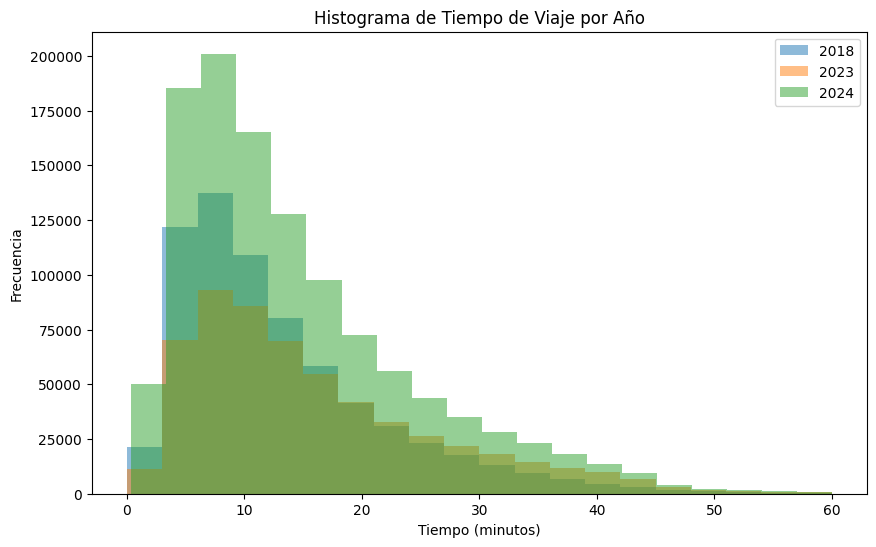

In [92]:
# Crear una figura y ejes para el histograma
fig, ax = plt.subplots(figsize=(10, 6))

# Iterar sobre cada año único y crear un histograma para cada uno
for año, datos_año in combined_csv_hora.groupby('Año'):
    ax.hist(datos_año['Delta_time_minutes'], bins=20, alpha=0.5, label=str(año))

# Agregar etiquetas y título al gráfico
ax.set_xlabel('Tiempo (minutos)')
ax.set_ylabel('Frecuencia')
ax.set_title('Histograma de Tiempo de Viaje por Año')
ax.legend()

# Mostrar el gráfico
plt.show()

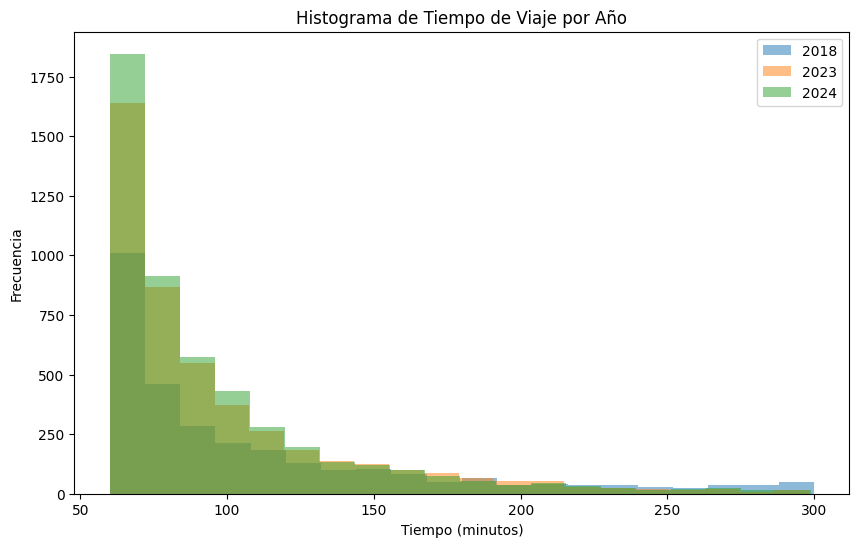

In [17]:
# Crear una figura y ejes para el histograma
fig, ax = plt.subplots(figsize=(10, 6))

# Iterar sobre cada año único y crear un histograma para cada uno
for año, datos_año in combined_csv_dia.groupby('Año'):
    ax.hist(datos_año['Delta_time_minutes'], bins=20, alpha=0.5, label=str(año))

# Agregar etiquetas y título al gráfico
ax.set_xlabel('Tiempo (minutos)')
ax.set_ylabel('Frecuencia')
ax.set_title('Histograma de Tiempo de Viaje por Año')
ax.legend()

# Mostrar el gráfico
plt.show()

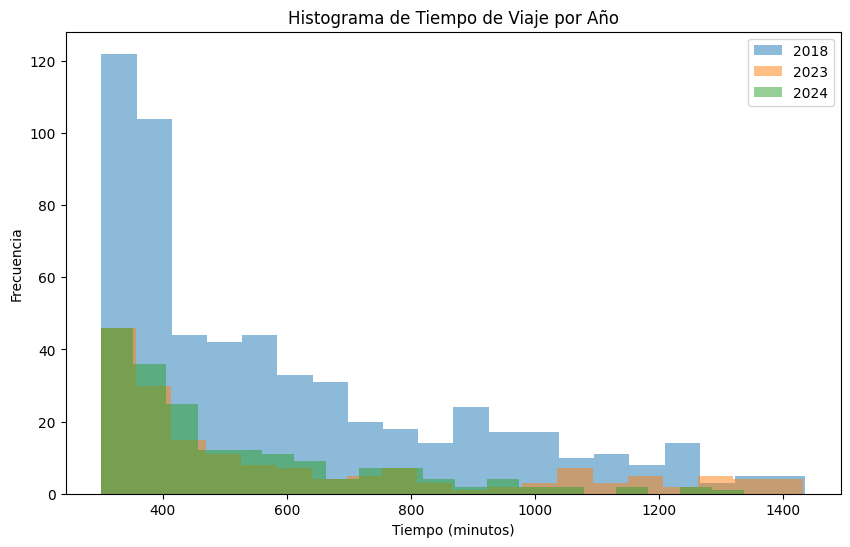

In [18]:
# Crear una figura y ejes para el histograma
fig, ax = plt.subplots(figsize=(10, 6))

# Iterar sobre cada año único y crear un histograma para cada uno
for año, datos_año in combined_csv_todo.groupby('Año'):
    ax.hist(datos_año['Delta_time_minutes'], bins=20, alpha=0.5, label=str(año))

# Agregar etiquetas y título al gráfico
ax.set_xlabel('Tiempo (minutos)')
ax.set_ylabel('Frecuencia')
ax.set_title('Histograma de Tiempo de Viaje por Año')
ax.legend()

# Mostrar el gráfico
plt.show()

In [71]:
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)*2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)*2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  
    return c * r

combined_csv_hora = combined_csv_hora.merge(estaciones_gdf, left_on='Ciclo_Estacion_Retiro', right_on='id')\
    .rename(columns={'lat': 'lat_retiro', 'lon': 'lon_retiro'})\
    .drop(columns='id')\
    .merge(estaciones_gdf, left_on='Ciclo_Estacion_Arribo', right_on='id')\
    .rename(columns={'lat': 'lat_arribo', 'lon': 'lon_arribo'})\
    .drop(columns='id')

combined_csv_hora['distancia'] = combined_csv_hora.apply(
    lambda row: haversine(row['lat_retiro'], row['lon_retiro'], row['lat_arribo'], row['lon_arribo']), axis=1)

C:\Users\Administrador\AppData\Local\Temp\ipykernel_4116\1481478323.py:6: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arcsin(np.sqrt(a))


In [72]:
combined_csv_hora.columns

Index(['Genero_Usuario', 'Edad_Usuario', 'Bici', 'Ciclo_Estacion_Retiro',
       'Fecha_Retiro', 'Hora_Retiro', 'Ciclo_Estacion_Arribo', 'Fecha_Arribo',
       'Hora_Arribo', 'Retiro', 'Arribo', 'Delta_time', 'Delta_time_minutes',
       'Año', 'lat_retiro', 'lon_retiro', 'name_x', 'geometry_x', 'lat_arribo',
       'lon_arribo', 'name_y', 'geometry_y', 'distancia'],
      dtype='object')

In [41]:
def bikeNetwork(df_data, df_posicion):
    # Data
    df = df_data.copy()
    df.dropna(inplace=True)
    
    # Graphs
    G = nx.Graph()
    G = nx.from_pandas_edgelist(df, 'Ciclo_Estacion_Retiro', 'Ciclo_Estacion_Arribo', edge_attr=['Delta_time_minutes','distancia'])

    # Figura
    fig, ax = plt.subplots(figsize=(20,10))

    # Posiciones
    pos = df_posicion.set_index('id')[['lon', 'lat']].apply(tuple, axis=1).to_dict()

    # Mapear atributo "pos" a nodos
    for node, position in pos.items():
        try:
            G.nodes[node]['pos'] = position
            #print('ok___' + str(node) +' ' + str(position))
        except KeyError:
            #print('error' + str(node) +' ' + str(position))
            pass
    # dibujar
    node_sizes = [(df['Ciclo_Estacion_Arribo'] == node).sum() for node in G.nodes()]
    # Normalize node sizes
    max_node_size = max(node_sizes)
    mean_node_size = sum(node_sizes) / len(node_sizes)
    normalized_node_sizes = [size* mean_node_size / max_node_size for size in node_sizes]
    nx.draw_networkx_nodes(G=G, pos=pos, node_size=normalized_node_sizes, node_color='blue', alpha=0.5)
    nx.draw_networkx_edges(G=G, pos=pos, edge_color='grey', style="dotted", alpha=0.1, arrows=False)
    ax.axis('off')
    return G

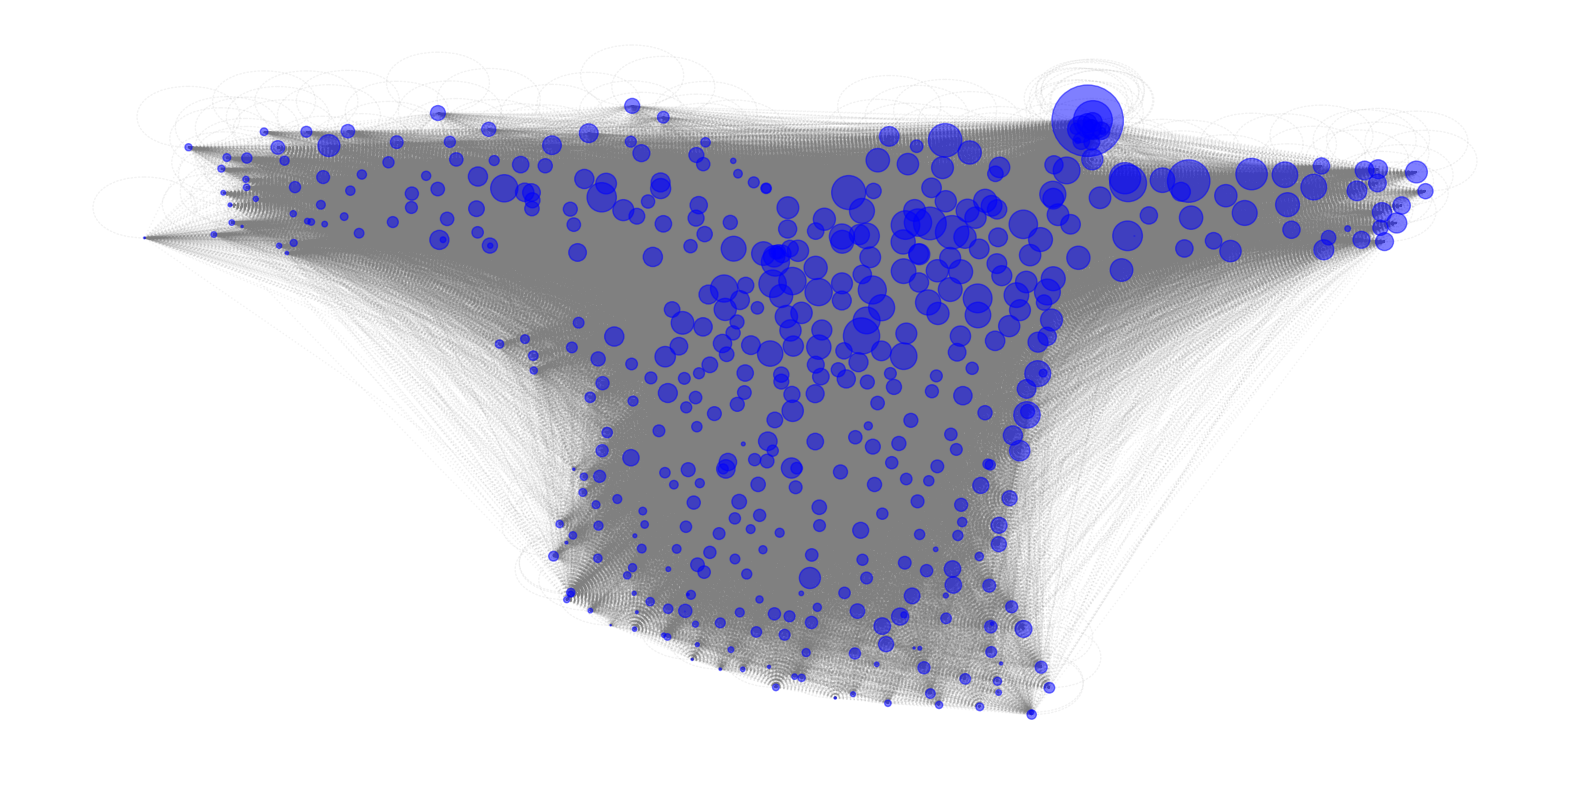

In [42]:
# Utilizar la función con estaciones_gdf y combined_csv_hora
G = bikeNetwork(combined_csv_hora, estaciones_gdf)

In [46]:
import community.community_louvain as cl
import matplotlib.cm as cm

def communityLouvain(G):
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Compute Louvain method
    partition = cl.best_partition(G)

    # Partition colormap
    cmap = plt.cm.get_cmap('tab20b', max(partition.values()) + 1)

    # Draw Nodes & Edges
    nodes = nx.draw_networkx_nodes(G, pos=nx.get_node_attributes(G, 'pos'), node_size=40, cmap=cmap, node_color=list(partition.values()))
    edges = nx.draw_networkx_edges(G, pos=nx.get_node_attributes(G, 'pos'), alpha=0.015)

    # Create colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(partition.values()), vmax=max(partition.values())))
    sm._A = []  # Fake up the array of the scalar mappable
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Community', rotation=270, labelpad=15)

    # Legend for communities
    for community_id, color in enumerate(cmap.colors):
        ax.plot([], [], color=color, label=f'Community {community_id}')

    # Labeling Axes
    ax.set_title('Red ECOBICI', fontdict={"fontsize":20}, pad=15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/jeyner777',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha=0.9)

    # Show legend
    ax.legend()

    plt.show()

C:\Users\Administrador\AppData\Local\Temp\ipykernel_4116\4144368860.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b', max(partition.values()) + 1)


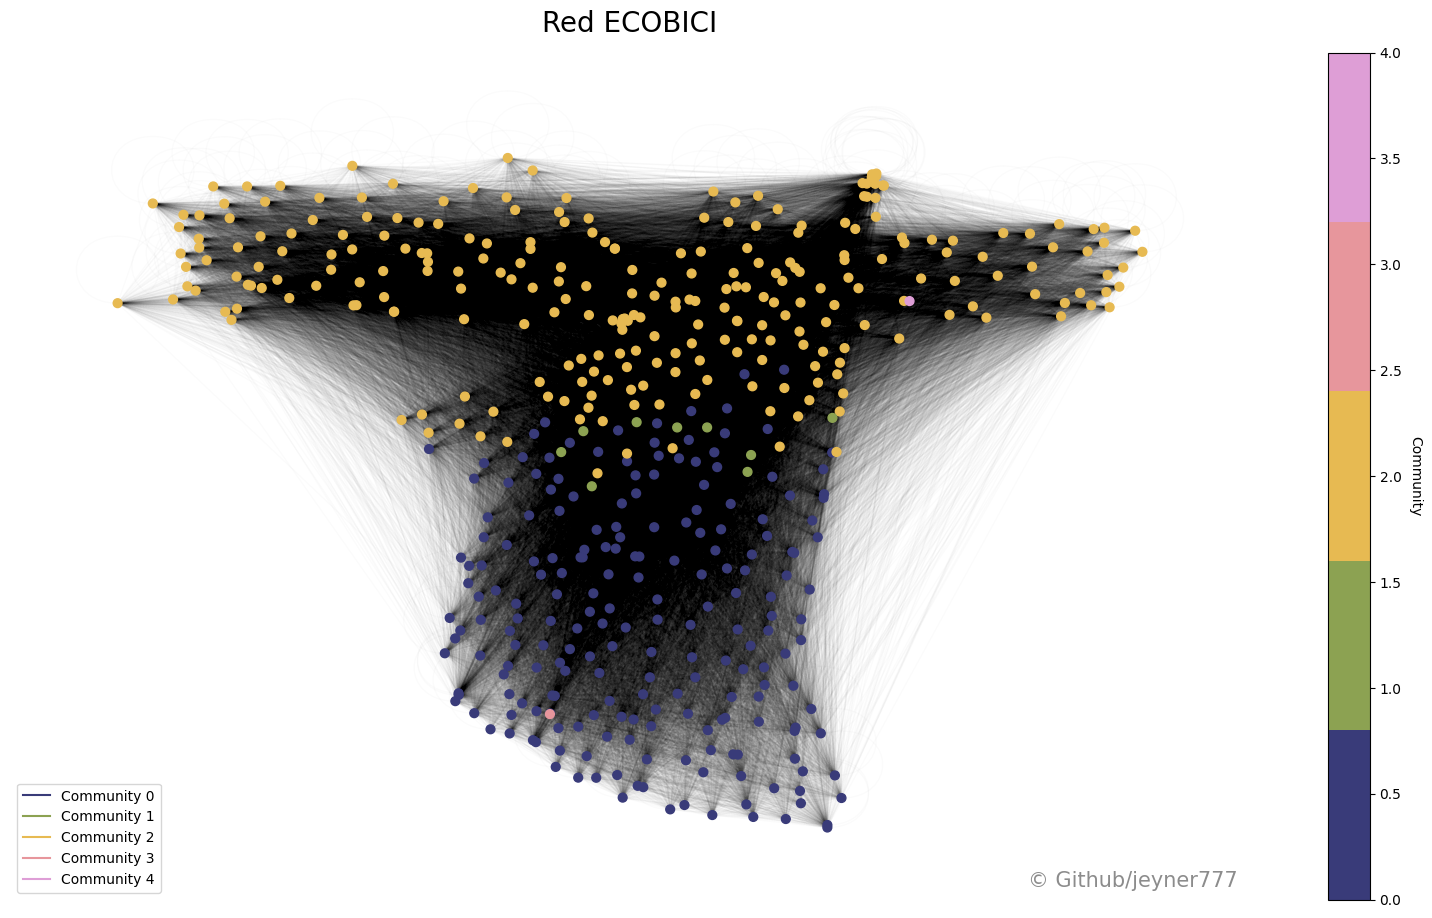

In [47]:
communityLouvain(G)

In [73]:
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import davies_bouldin_score

In [107]:
X = estaciones_gdf[['lon', 'lat']].values
n_clusters_ = 4
kmeans = KMeans(n_clusters = n_clusters_, init ='k-means++')
kmeans.fit(X) # Compute k-means clustering.
labels = kmeans.fit_predict(X)

In [108]:
# Coordinates of cluster centers.
centers = kmeans.cluster_centers_ 

# map each station with its region
estaciones_gdf['clusters']=labels
estaciones_gdf.index=estaciones_gdf['id']
cluster_map = estaciones_gdf['clusters'].to_dict()
combined_csv_hora['de_station_c']=combined_csv_hora['Ciclo_Estacion_Retiro'].map(cluster_map)
combined_csv_hora['a_station_c']=combined_csv_hora['Ciclo_Estacion_Arribo'].map(cluster_map)

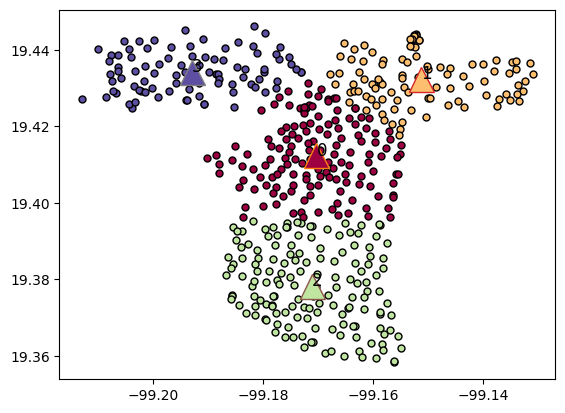

In [109]:
import matplotlib.image as mpimg
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
BBox = (-79.4900,-79.2700,43.6100,43.7200)
# map_tor = mpimg.imread('map.png')
fig, ax = plt.subplots()
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask]
    ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)
    ax.plot(centers[k, 0], centers[k, 1], '^',markerfacecolor=tuple(col), markersize=18)
    ax.text(centers[k, 0], centers[k, 1], k,fontsize=12)
# ax.set_xlim(BBox[0],BBox[1])
# ax.set_ylim(BBox[2],BBox[3])
# ax.imshow(map_tor, zorder=0, extent = BBox, aspect= 'equal')
plt.show()

In [84]:
node_attributes = nx.get_node_attributes(G, 'pos')  # Reemplaza 'attribute_name' por el nombre del atributo que deseas utilizar

# Convertir los atributos en una matriz numpy
feature_matrix = np.array([list(attributes.values()) for attributes in node_attributes.values()])

print(feature_matrix)

AttributeError: 'tuple' object has no attribute 'values'

In [77]:
def optimal_clusters(X, max_clusters):
    # Calcular la matriz de adyacencia utilizando los vecinos más cercanos
    A = kneighbors_graph(X, n_neighbors=5, mode='distance')
    
    davies_bouldin_scores = []
    
    for n_clusters in range(2, max_clusters + 1):
        # Aplicar KMeans para agrupar los nodos
        kmeans = KMeans(n_clusters=n_clusters)
        labels = kmeans.fit_predict(A)
        
        # Calcular el índice Davies-Bouldin
        db_score = davies_bouldin_score(X, labels)
        davies_bouldin_scores.append(db_score)
        
    # Encontrar el número óptimo de clusters que minimiza el índice Davies-Bouldin
    optimal_n_clusters = davies_bouldin_scores.index(min(davies_bouldin_scores)) + 2  # +2 debido a que comenzamos desde n_clusters = 2
    
    return optimal_n_clusters

In [78]:
optimal_n_clusters = optimal_clusters(G, max_clusters=10)

ValueError: Expected 2D array, got 1D array instead:
array=[ 18 124 450   9   6  31 254 158 136 121 123  16 109 270   1  19 116  86
  20 272  41  37 131 373 169 179  84  56 326  54 280  58  47  23 173 184
 234 204 285 167 224 249 197 271 290 182 227 180  26  43 238  32 112  42
  63 165 233  38 129 419 385 215 245 349 172  49  39 340  34 198 208 163
 333 194 287  69 113 295 308 255  52  90 390  35   8 150 148   4  24  45
 440 431 278  46 178  97  89 107 346 277  88 386 307 232 416 344  70  77
 304  87 320 439 413 193 444  67 146 243 242 321  51  72 286 147  64 145
  74 130  53 406 337 133 195 126  81 402  83 348 299 291 186 114  57  61
  12  66  40   5 189 369  80   3  17 183  28 218  85  68 228 252 174 170
 209  76 452 164 143 358 141 144 119 134  75 430 405 128 302  11 103 135
 256 331 240 200 125 415 412 110 262  29 436 370 371 288  22 338 154 377
 318  14  99 427 398  15 166 188 187 319 201 120 149  79 192 171 283  55
 219 258 305 447 342 207   2 422 429 393 372 118 111 276 159 375 140  21
 181 316 312 137 117  10 214  73 223  96 211 310 317 323  62 315 206 384
 329 428 248  59 351 332 400  92   7 359 297 292 325 366 363 387 380 281
 152 368  44 217 153 251 246 396 122 425 177 226 306 132 225 448 106 237
 314 438 313 335 301 404 441 426 168 394  98 162 303 407 142  60 423 298
 356 328 435 102  94  71 433 432 151 414 334 392 138 353 185 420 213 374
 157 347 161 341 383 104 379 395 381 230 401 216 352 221  50 294  78 354
 443 236 231 336 239 202 191 284 409 101 424 279 357 263 350 229 203 389
 261 399 322 437 421 250 205 446 397 105 293 289 364 309 410 442 451 330
 220  13 210 418 362 127 365 253 235 244 196 378 367 382 324 339 361 343
  93 311 345 199 355  65 376  36 417 388 403 411 300 391 108 360 434 273
 274 176 267 266 269 264 268 275 265 115  25 155 190 449 160 260 139 175
 454 461  30  91  82 259 327 467 466 469 476 472 282 475  33 212 464 479
 156 100  48  95 222 241 247 456 445 460 457 459 468  27 480 470 257 474
 478 465 455 296 473 477 471 463 453 462 458].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [102]:
# Obtener las aristas del grafo G
edges = G.edges(data=True)
len(edges)
# Iterar sobre las aristas y obtener los atributos de cada una
for u, v, attributes in edges:
    # `u` y `v` son los nodos conectados por la arista
    # `attributes` es un diccionario que contiene los atributos de la arista
    print(f"Arista entre los nodos {u} y {v}: {attributes}")

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Arista entre los nodos 323 y 210: {'Delta_time_minutes': 27.95, 'distancia': 224.29465808078112}
Arista entre los nodos 323 y 190: {'Delta_time_minutes': 21.05, 'distancia': 81.89734342533511}
Arista entre los nodos 323 y 261: {'Delta_time_minutes': 27.4, 'distancia': 281.0323385397283}
Arista entre los nodos 323 y 414: {'Delta_time_minutes': 12.116666666666667, 'distancia': 281.7673577069444}
Arista entre los nodos 323 y 381: {'Delta_time_minutes': 12.4, 'distancia': 273.43053250413305}
Arista entre los nodos 323 y 460: {'Delta_time_minutes': 43.31666666666667, 'distancia': 154.08639477830548}
Arista entre los nodos 323 y 453: {'Delta_time_minutes': 31.633333333333333, 'distancia': 13.740234764546514}
Arista entre los nodos 323 y 253: {'Delta_time_minutes': 28.433333333333334, 'distancia': 260.2114137116949}
Arista entre los nodos 323 y 104: {'Delta_time_minutes': 27.933333333333334, 'distancia': 417.2531859362463}
Arista entre los nodos 323 y 466: {'Delta_time_minutes': 42.8166666666

In [104]:
combined_csv_hora[(combined_csv_hora['Ciclo_Estacion_Retiro'] == node_x) &(combined_csv_hora['Ciclo_Estacion_Arribo'] == node_y)]['Delta_time_minutes'].mean()

961706      4.566667
962791     12.366667
1082493     6.466667
1085056    41.450000
1344990     5.366667
             ...    
2792085     7.600000
2794609    17.466667
2796592     7.550000
2799487    10.166667
2801266    13.633333
Name: Delta_time_minutes, Length: 79, dtype: float64

In [105]:
# Lista para almacenar los datos de cada combinación de nodos
data = []

# Iterar sobre todos los nodos únicos
unique_nodes = combined_csv_hora['Ciclo_Estacion_Retiro'].unique()
for node_x in unique_nodes:
    for node_y in unique_nodes:
        if node_x != node_y:
            # Calcular el promedio de Delta_time_minutes
            delta_time_avg = combined_csv_hora[(combined_csv_hora['Ciclo_Estacion_Retiro'] == node_x) & 
                                                (combined_csv_hora['Ciclo_Estacion_Arribo'] == node_y)]['Delta_time_minutes'].mean()
            # Agregar los datos a la lista
            data.append({'Nodo_Origen': node_x, 'Nodo_Destino': node_y, 'Delta_time_minutes_avg': delta_time_avg})

# Crear un DataFrame con los datos recopilados
df_result = pd.DataFrame(data)
df_result

Nodo_Origen  Nodo_Destino  Delta_time_minutes_avg
0                18            16                8.281825
1                18             9                8.113218
2                18            31                9.255035
3                18           169               20.435417
4                18            54               15.865556
...             ...           ...                     ...
228957          458           471               22.711111
228958          458           296               47.833333
228959          458           477               22.850000
228960          458           453                5.308333
228961          458           463               13.240909

[228962 rows x 3 columns]

In [120]:
df_result.to_csv('tiempos_entre_nodos.csv', index=False)